<a href="https://colab.research.google.com/github/hoonzi-s/APC/blob/main/%231ALK_213BTMRVP_R4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

## Get Data

In [3]:
data_origin = pd.read_csv('https://raw.githubusercontent.com/hoonzi-s/APC/main/%231%20ALK%20RVP%20CSV.csv', index_col = 0)
data_origin.info()
data_origin.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 2753 entries, 2014-09-16 to 2022-06-30
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RVP_LAB         2753 non-null   float64
 1   S.B5.213TI2804  2753 non-null   float64
 2   S.B5.213PI2806  2753 non-null   float64
 3   S.B5.213FC2602  2753 non-null   float64
dtypes: float64(4)
memory usage: 107.5+ KB


,RVP_LAB,S.B5.213TI2804,S.B5.213PI2806,S.B5.213FC2602
count,2753.00000,2753.000000,2753.000000,2753.000000
mean,39.41551,133.889974,335.177430,85.890540
std,3.53523,3.471188,29.578899,10.688965
min,28.50000,98.364672,293.412469,33.324527
25%,37.50000,131.923775,318.182670,81.066149
50%,39.00000,133.375011,325.641719,88.489940
75%,40.80000,136.082275,339.128497,92.699854
max,98.60000,145.946073,516.111992,112.931605


In [4]:
data_origin.columns = ['RVP', 'T', 'P', 'F']
data = data_origin[(data_origin['RVP'] < 70) & (data_origin['T'] > 120)]
data.iloc[:, 1] += 273.15     # to Absolute
data.iloc[:, 2] += 101.325    # to Absolute
data

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


,RVP,T,P,F
2014-09-16,35.5,409.936039,436.615024,89.866631
2014-09-17,33.5,411.923619,439.539453,89.465610
2014-09-18,34.4,411.249435,440.881301,91.788269
2014-09-19,34.3,410.475546,437.095474,96.439654
2014-09-20,35.2,410.551238,451.085975,91.357863
...,...,...,...,...
2022-06-26,49.2,404.399490,470.510546,83.462000
2022-06-27,50.9,403.708482,486.321257,85.722808
2022-06-28,56.8,402.141628,504.938888,84.932767
2022-06-29,50.9,402.835703,480.513489,79.402347


In [5]:
A = 7.00961   # Temperature in Celsius
B = 1022.48
C = 248.145
P_ref = (335 / 101.325 + 1) * 760   # kPa to mmHg(Absolute)
conv = 760 / 101.325    # kPa to mmHg conversion factor
data['PCT'] = data.iloc[:, 1] + B * np.log10(P_ref / (data.iloc[:, 2] * conv)) / (A - np.log10(P_ref)) / (A - np.log10(data.iloc[:, 2] * conv))
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,RVP,T,P,F,PCT
2014-09-16,35.5,409.936039,436.615024,89.866631,409.911877
2014-09-17,33.5,411.923619,439.539453,89.465610,411.656493
2014-09-18,34.4,411.249435,440.881301,91.788269,410.871233
2014-09-19,34.3,410.475546,437.095474,96.439654,410.411384
2014-09-20,35.2,410.551238,451.085975,91.357863,409.336512
...,...,...,...,...,...
2022-06-26,49.2,404.399490,470.510546,83.462000,401.630900
2022-06-27,50.9,403.708482,486.321257,85.722808,399.710220
2022-06-28,56.8,402.141628,504.938888,84.932767,396.733150
2022-06-29,50.9,402.835703,480.513489,79.402347,399.285613


## Set 'n' and 'information'

In [6]:
n = 20
information = pd.DataFrame(columns=['Variables', 'Solution', 'Alpha', 'Scaler', 'train_R2', 'test_R2', 'MAE', 'MSE'])
information

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE


# Poly T, P

## LinearRegression

In [7]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []

vars = 'Poly T, P'
soln = 'LinearRegression'
alpha = np.nan
scaler = 'Standard'

In [158]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = LinearRegression()
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
  new = pd.DataFrame({'Variables': vars, 
                      'Solution': soln, 
                      'Alpha': alpha, 
                      'Scaler': scaler, 
                      'train_R2': np.mean(train_R2), 
                      'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                      'R2_inv': 1 - np.mean(r2),
                      'MAE': np.mean(mae), 
                      'MSE': np.mean(mse)}, 
                    index = [0])
  information = pd.concat([information, new])
  new

  print(model.coef_)
  print(model.intercept_)
# print(pf.get_feature_names_out())

[  0.         -11.57425237  14.75525717  36.87653268  12.50512236
  -9.3125646  -38.99430978  -5.55451427   5.36132858  -1.91954627]
39.3955326460481
[  0.           3.53709694  19.69770951  53.64269632  -0.6740401
 -17.55912344 -54.32377456  -2.05933224   4.00690801  -2.01530648]
39.40608738340698
[  0.          11.1141878   20.50957277  57.10842712  -8.35664951
 -15.63810484 -56.18060661  -4.01205872   2.74296242  -2.50136022]
39.43308787432499
[  0.          -0.14515653   7.08756158  56.58263694   1.12132731
   0.67644995 -57.12288035  -6.80366028   4.74887605  -2.68193629]
39.437457044673536
[  0.           1.05100954  13.98502209  53.08963402   0.55188438
  -7.78115404 -53.09579951  -5.26533377   3.53171625  -2.36373706]
39.374079528718696
[  0.          10.77206674   5.59651505  53.35689039 -10.13217736
   1.87754503 -53.38016525  -5.86496273   3.45013933  -2.1730341 ]
39.37103583701522
[  0.           9.78459456  -7.19200143  49.88879807 -10.98929981
  16.89733745 -51.01363491  

## Ridge

### Ridge (alpha = 0.001)

In [9]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Ridge'
alpha = 0.001
scaler = 'Standard'

In [10]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Ridge,0.001,Standard,0.57411,0.559929,0.570464,0.429536,1.609476,4.811441


### Ridge (alpha = 0.01)

In [11]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Ridge'
alpha = 0.01
scaler = 'Standard'

In [12]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Ridge,0.01,Standard,0.57076,0.566426,0.570114,0.429886,1.608957,4.81536


### Ridge (alpha = 0.1)

In [13]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Ridge'
alpha = 0.1
scaler = 'Standard'

In [14]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Ridge,0.1,Standard,0.56342,0.574006,0.566589,0.433411,1.614677,4.854846


### Ridge (alpha = 1)

In [15]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Ridge'
alpha = 1
scaler = 'Standard'

In [16]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Ridge,1,Standard,0.564532,0.559494,0.564009,0.435991,1.618996,4.88374


### Ridge (alpha = 10)

In [17]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Ridge'
alpha = 10
scaler = 'Standard'

In [18]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Ridge,10,Standard,0.559827,0.553636,0.558624,0.441376,1.627243,4.944058


### Ridge (alpha = 100)

In [19]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Ridge'
alpha = 100
scaler = 'Standard'

In [20]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Ridge,100,Standard,0.554702,0.551197,0.553937,0.446063,1.631415,4.996559


## Lasso

### Lasso (alpha = 0.001)

In [21]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Lasso'
alpha = 0.001
scaler = 'Standard'

In [22]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 30000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Lasso,0.001,Standard,0.565003,0.564507,0.565267,0.434733,1.616068,4.86965


### Lasso (alpha = 0.01)

In [23]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Lasso'
alpha = 0.01
scaler = 'Standard'

In [24]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 1000000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Lasso,0.01,Standard,0.558146,0.557114,0.557935,0.442065,1.628153,4.951782


### Lasso (alpha = 0.1)

In [25]:
input = data[['T', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P'
soln = 'Lasso'
alpha = 0.1
scaler = 'Standard'

In [26]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 1000000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P",Lasso,0.1,Standard,0.556413,0.545934,0.554196,0.445804,1.628547,4.99366


# Poly PCT, P

## LinearRegression

In [27]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'LinearRegression'
alpha = np.nan
scaler = 'Standard'

In [28]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = LinearRegression()
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",LinearRegression,NaN,Standard,0.573643,0.559201,0.570572,0.429428,1.608366,4.810225


## Ridge

### Ridge (alpha = 0.001)

In [29]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 0.001
scaler = 'Standard'

In [30]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Ridge,0.001,Standard,0.571564,0.56669,0.570789,0.429211,1.607691,4.807801


### Ridge (alpha = 0.01)

In [31]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 0.01
scaler = 'Standard'

In [32]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Ridge,0.01,Standard,0.574365,0.557679,0.570447,0.429553,1.607204,4.811625


### Ridge (alpha = 0.1)

In [33]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 0.1
scaler = 'Standard'

In [34]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Ridge,0.1,Standard,0.573973,0.548379,0.568281,0.431719,1.611764,4.835891


### Ridge (alpha = 1)

In [35]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 1
scaler = 'Standard'

In [36]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Ridge,1,Standard,0.565941,0.560246,0.565074,0.434926,1.616408,4.871809


### Ridge (alpha = 10)

In [37]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 10
scaler = 'Standard'

In [38]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Ridge,10,Standard,0.560021,0.567153,0.56207,0.43793,1.620994,4.905465


### Ridge (alpha = 100)

In [39]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Ridge'
alpha = 100
scaler = 'Standard'

In [40]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Ridge,100,Standard,0.560808,0.554478,0.559671,0.440329,1.62369,4.932328


## Lasso

### Lasso (alpha = 0.001)

In [41]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Lasso'
alpha = 0.001
scaler = 'Standard'

In [42]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 30000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Lasso,0.001,Standard,0.566207,0.562534,0.565514,0.434486,1.616832,4.866887


### Lasso (alpha = 0.01)

In [43]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Lasso'
alpha = 0.01
scaler = 'Standard'

In [44]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 2000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Lasso,0.01,Standard,0.560288,0.562108,0.560911,0.439089,1.623063,4.918439


### Lasso (alpha = 0.1)

In [45]:
input = data[['PCT', 'P']]
target = data['RVP']

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P'
soln = 'Lasso'
alpha = 0.1
scaler = 'Standard'

In [46]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P",Lasso,0.1,Standard,0.561039,0.553216,0.559339,0.440661,1.621639,4.936055


# Poly PCT, P, F

## LinearRegression

In [47]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'LinearRegression'
alpha = np.nan
scaler = 'Standard'

In [48]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = LinearRegression()
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",LinearRegression,NaN,Standard,0.585941,0.585134,0.585995,0.414005,1.572142,4.637466


## Ridge

### Ridge (alpha = 0.001)

In [49]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 0.001
scaler = 'Standard'

In [50]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Ridge,0.001,Standard,0.591682,0.565007,0.58562,0.41438,1.573388,4.641667


### Ridge (alpha = 0.01)

In [51]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 0.01
scaler = 'Standard'

In [52]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Ridge,0.01,Standard,0.590115,0.570276,0.585453,0.414547,1.57286,4.643536


### Ridge (alpha = 0.1)

In [53]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 0.1
scaler = 'Standard'

In [54]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Ridge,0.1,Standard,0.585345,0.569631,0.581603,0.418397,1.575976,4.686663


### Ridge (alpha = 1)

In [55]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 1
scaler = 'Standard'

In [56]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Ridge,1,Standard,0.580087,0.565455,0.57708,0.42292,1.579967,4.737322


### Ridge (alpha = 10)

In [57]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 10
scaler = 'Standard'

In [58]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Ridge,10,Standard,0.57992,0.556088,0.574205,0.425795,1.582598,4.769526


### Ridge (alpha = 100)

In [59]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Ridge'
alpha = 100
scaler = 'Standard'

In [60]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Ridge,100,Standard,0.571889,0.568539,0.571586,0.428414,1.58671,4.798866


## Lasso

### Lasso (alpha = 0.001)

In [61]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Lasso'
alpha = 0.001
scaler = 'Standard'

In [62]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 30000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.493e+00, tolerance: 2.193e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.490e+01, tolerance: 2.430e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisa

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Lasso,0.001,Standard,0.582974,0.564098,0.578178,0.421822,1.57806,4.725022


### Lasso (alpha = 0.01)

In [63]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Lasso'
alpha = 0.01
scaler = 'Standard'

In [64]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 2000)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Lasso,0.01,Standard,0.572248,0.573369,0.572834,0.427166,1.584992,4.784892


### Lasso (alpha = 0.1)

In [65]:
input = data[['PCT', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly PCT, P, F'
soln = 'Lasso'
alpha = 0.1
scaler = 'Standard'

In [66]:
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly PCT, P, F",Lasso,0.1,Standard,0.57233,0.560478,0.569496,0.430504,1.591769,4.822281


# Poly T, P, F

## LinearRegression

In [138]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'LinearRegression'
alpha = np.nan
scaler = 'Standard'

In [142]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = LinearRegression()
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

print(model.coef_)
print(model.intercept_)
# print(pf.get_feature_names())
print(pf.get_feature_names_out())

[  0.          11.05254591   1.75256085  54.85839    -10.93781518
   6.38864288 -54.43132447  -5.7496805    2.6563828   -2.01743397]
39.42439862542955
['1' 'T' 'P' 'F' 'T^2' 'T P' 'T F' 'P^2' 'P F' 'F^2']


[  0.          10.78103635   4.36549961  48.0406989  -10.92323058
   4.34025154 -48.35181365  -6.77107737   3.31706367  -1.95961431]
39.44585174275896
['1', 'x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2']
['1' 'T' 'P' 'F' 'T^2' 'T P' 'T F' 'P^2' 'P F' 'F^2']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


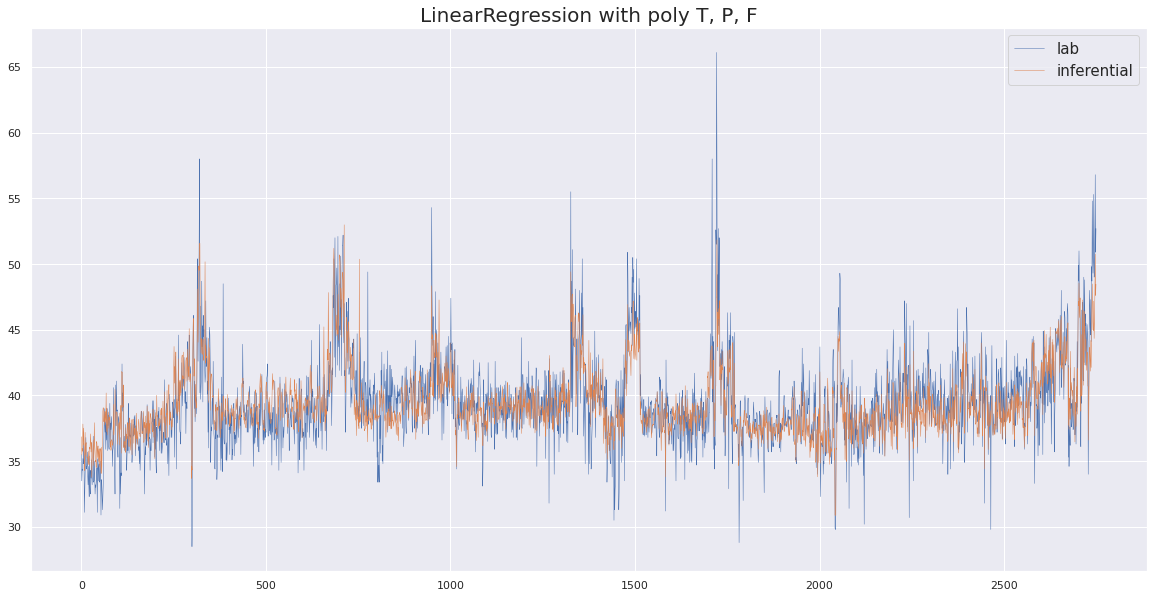

In [69]:
plt.figure(figsize = (20, 10))
plt.plot(np.arange(2750), target, label = 'lab', lw = 0.5)
plt.plot(np.arange(2750), inferential, label = 'inferential', lw = 0.5)
plt.legend(fontsize = 15)
plt.title('LinearRegression with poly T, P, F', fontsize = 20)
plt.show()

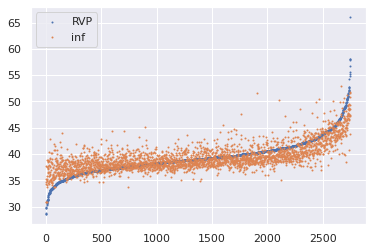

In [70]:
test = pd.DataFrame(target)
test['inf'] = inferential
test = test.sort_values(by = 'RVP')
# test = test.sort_values(by = 'inf')
test.reset_index(drop = True)
plt.scatter(np.arange(2750), test['RVP'], label = 'RVP', s = 1)
plt.scatter(np.arange(2750), test['inf'], label = 'inf', s = 1)
plt.legend()

## Ridge

### Ridge (alpha = 0.001)

In [71]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 0.001
scaler = 'Standard'

In [72]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Ridge,0.001,Standard,0.589386,0.574947,0.585968,0.414032,1.572148,4.637773


### Ridge (alpha = 0.01)

In [73]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 0.01
scaler = 'Standard'

In [74]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Ridge,0.01,Standard,0.586328,0.5831,0.586007,0.413993,1.570829,4.637326


### Ridge (alpha = 0.1)

In [75]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 0.1
scaler = 'Standard'

In [76]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Ridge,0.1,Standard,0.576644,0.594274,0.581607,0.418393,1.575664,4.686614


### Ridge (alpha = 1)

In [77]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 1
scaler = 'Standard'

In [78]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Ridge,1,Standard,0.577525,0.573725,0.576925,0.423075,1.580096,4.739061


### Ridge (alpha = 10)

In [79]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 10
scaler = 'Standard'

In [80]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Ridge,10,Standard,0.574096,0.559754,0.570671,0.429329,1.588943,4.809114


### Ridge (alpha = 100)

In [81]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Ridge'
alpha = 100
scaler = 'Standard'

In [82]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  sc = StandardScaler()
  sc.fit(train_input)
  input_poly = sc.transform(input_poly)
  train_poly = sc.transform(train_input)
  test_poly = sc.transform(test_input)

  model = Ridge(alpha = alpha)
  model.fit(train_poly, train_target)

  train_R2.append(model.score(train_poly, train_target))
  test_R2.append(model.score(test_poly, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
      
new = pd.DataFrame({'Variables': vars, 
                    'Solution': soln, 
                    'Alpha': alpha, 
                    'Scaler': scaler, 
                    'train_R2': np.mean(train_R2), 
                    'test_R2': np.mean(test_R2), 
                    'R2': np.mean(r2),
                    'R2_inv': 1 - np.mean(r2),
                    'MAE': np.mean(mae), 
                    'MSE': np.mean(mse)}, 
                   index = [0])
information = pd.concat([information, new])
new

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,R2,R2_inv,MAE,MSE
0,"Poly T, P, F",Ridge,100,Standard,0.564161,0.564937,0.564642,0.435358,1.597705,4.87665


## Lasso

### Lasso (alpha = 0.001)

In [143]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Lasso'
alpha = 0.001
scaler = 'Standard'

In [150]:
# for i in range(n):
train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
sc = StandardScaler()
sc.fit(train_input)
input_poly = sc.transform(input_poly)
train_poly = sc.transform(train_input)
test_poly = sc.transform(test_input)

model = Lasso(alpha = alpha, max_iter = 300000)
model.fit(train_poly, train_target)

train_R2.append(model.score(train_poly, train_target))
test_R2.append(model.score(test_poly, test_target))
inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
mae.append(MAE(target, inferential))
mse.append(MSE(target, inferential))
r2.append(r2_score(target, inferential))
    
new = pd.DataFrame({'Variables': vars, 
                  'Solution': soln, 
                  'Alpha': alpha, 
                  'Scaler': scaler, 
                  'train_R2': np.mean(train_R2), 
                  'test_R2': np.mean(test_R2), 
                  'R2': np.mean(r2),
                  'R2_inv': 1 - np.mean(r2),
                  'MAE': np.mean(mae), 
                  'MSE': np.mean(mse)}, 
                  index = [0])
information = pd.concat([information, new])
new

print(model.coef_)
# print(pf.get_feature_names())
print(pf.get_feature_names_out())

[ 0.         -2.1910955   8.39700769  8.3114747  -0.          0.
 -8.24107333 -4.83139902 -0.9152627   0.36181405]
['1' 'T' 'P' 'F' 'T^2' 'T P' 'T F' 'P^2' 'P F' 'F^2']


[ 0.         -2.71750514  7.65032194  0.         -0.          0.
 -0.07720108 -4.17707729 -0.94739329  0.39749649]
['1' 'T' 'P' 'F' 'T^2' 'T P' 'T F' 'P^2' 'P F' 'F^2']


### Lasso (alpha = 0.01)

In [153]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Lasso'
alpha = 0.01
scaler = 'Standard'

In [161]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  # sc = StandardScaler()
  # sc.fit(train_input)
  # input_poly = sc.transform(input_poly)
  # train_poly = sc.transform(train_input)
  # test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 30000)
  # model.fit(train_poly, train_target)
  model.fit(train_input, train_target) 
  # train_R2.append(model.score(train_poly, train_target))
  # test_R2.append(model.score(test_poly, test_target))
  
  train_R2.append(model.score(train_input, train_target))
  test_R2.append(model.score(test_input, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
        
  new = pd.DataFrame({'Variables': vars, 
                      'Solution': soln, 
                      'Alpha': alpha, 
                      'Scaler': scaler, 
                      'train_R2': np.mean(train_R2), 
                      'test_R2': np.mean(test_R2), 
                      'R2': np.mean(r2),
                      'R2_inv': 1 - np.mean(r2),
                      'MAE': np.mean(mae), 
                      'MSE': np.mean(mse)}, 
                    index = [0])
  information = pd.concat([information, new])
  # print(new)

  print(model.coef_)
  print(model.intercept_)
  # print(pf.get_feature_names_out())

[ 0.         -2.59965545  2.8975895  -0.         -0.          0.
 -0.35525105 -0.         -0.         -0.        ]
39.357638657792776
[ 0.         -1.39142394  2.90266106 -0.         -1.20693342  0.
 -0.39619685 -0.         -0.         -0.        ]
39.410626784380504
[ 0.         -0.95728387  2.97503901 -0.         -1.70058725  0.
 -0.37465423 -0.         -0.         -0.        ]
39.385982770793014
[ 0.         -2.68098846  2.9497839  -0.         -0.          0.
 -0.39187076 -0.         -0.         -0.        ]
39.39329283287795
[ 0.         -2.5597753   2.91315955 -0.         -0.          0.
 -0.33624855 -0.         -0.         -0.        ]
39.40343295401152
[ 0.         -2.63618724  2.89024809 -0.         -0.          0.
 -0.34308427 -0.         -0.         -0.        ]
39.4015833145555
[ 0.         -2.63126469  2.85101241 -0.         -0.          0.
 -0.37165005 -0.         -0.         -0.        ]
39.34331206656946
[ 0.         -2.66097982  2.91305481 -0.         -0.          0.
 -

In [155]:
# print(model.coef_)
# print(pf.get_feature_names())
print(pf.get_feature_names_out())

['1' 'T' 'P' 'F' 'T^2' 'T P' 'T F' 'P^2' 'P F' 'F^2']


### Lasso (alpha = 0.1)

In [162]:
input = data[['T', 'P', 'F']]

pf = PolynomialFeatures()
pf.fit(input)
input_poly = pf.transform(input)

train_R2 = []
test_R2 = []
mae = []
mse = []
r2 = []
vars = 'Poly T, P, F'
soln = 'Lasso'
alpha = 0.1
scaler = 'Standard'

In [163]:
for i in range(n):
  train_input, test_input, train_target, test_target = tts(input_poly, target, test_size = 7/27)
  # sc = StandardScaler()
  # sc.fit(train_input)
  # input_poly = sc.transform(input_poly)
  # train_poly = sc.transform(train_input)
  # test_poly = sc.transform(test_input)

  model = Lasso(alpha = alpha, max_iter = 300000)
  # model.fit(train_poly, train_target)
  model.fit(train_input, train_target) 
  # train_R2.append(model.score(train_poly, train_target))
  # test_R2.append(model.score(test_poly, test_target))
  
  train_R2.append(model.score(train_input, train_target))
  test_R2.append(model.score(test_input, test_target))
  inferential = np.sum(model.coef_ * input_poly, axis = 1) + model.intercept_
  mae.append(MAE(target, inferential))
  mse.append(MSE(target, inferential))
  r2.append(r2_score(target, inferential))
        
  new = pd.DataFrame({'Variables': vars, 
                      'Solution': soln, 
                      'Alpha': alpha, 
                      'Scaler': scaler, 
                      'train_R2': np.mean(train_R2), 
                      'test_R2': np.mean(test_R2), 
                      'R2': np.mean(r2),
                      'R2_inv': 1 - np.mean(r2),
                      'MAE': np.mean(mae), 
                      'MSE': np.mean(mse)}, 
                    index = [0])
  information = pd.concat([information, new])
  # print(new)

  print(model.coef_)
  print(model.intercept_)
  # print(pf.get_feature_names_out())

[ 0.         -0.          0.          0.         -0.00127297  0.00074178
 -0.00110039 -0.0002991   0.00087072  0.00023518]
179.8166090175515
[ 0.         -0.          0.          0.         -0.00154164  0.00096598
 -0.00037979 -0.00032785  0.00017348  0.00022144]
191.055815301288
[ 0.         -0.          0.          0.         -0.00141911  0.00082626
 -0.00039864 -0.00027249  0.0002266   0.00017651]
184.01194871498228
[ 0.         -0.          0.          0.         -0.00142665  0.00079578
 -0.00052761 -0.00025101  0.0001556   0.00065769]
190.12420411457057
[ 0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.47529337e-03  8.88233217e-04 -2.21072317e-04 -2.87894281e-04
  9.55812102e-05  1.80204826e-05]
185.09076240635238
[ 0.         -0.          0.          0.         -0.00131537  0.00069433
 -0.0005531  -0.00022665  0.0003202   0.00030651]
182.33807379301203
[ 0.         -0.          0.          0.         -0.00136392  0.00080697
 -0.00096982 -0.00030598  0.00067812 

In [91]:
print(model.coef_)
# print(pf.get_feature_names())
print(pf.get_feature_names_out())

[ 0.         -2.31426918  2.71369086 -0.         -0.          0.
 -0.15146367  0.         -0.         -0.        ]
['1' 'T' 'P' 'F' 'T^2' 'T P' 'T F' 'P^2' 'P F' 'F^2']


# Result

In [92]:
information

,Variables,Solution,Alpha,Scaler,train_R2,test_R2,MAE,MSE,R2,R2_inv
0,"Poly T, P",LinearRegression,NaN,Standard,0.571717,0.566013,1.608615,4.810489,0.570548,0.429452
0,"Poly T, P",Ridge,0.001,Standard,0.574110,0.559929,1.609476,4.811441,0.570464,0.429536
0,"Poly T, P",Ridge,0.010,Standard,0.570760,0.566426,1.608957,4.815360,0.570114,0.429886
0,"Poly T, P",Ridge,0.100,Standard,0.563420,0.574006,1.614677,4.854846,0.566589,0.433411
0,"Poly T, P",Ridge,1.000,Standard,0.564532,0.559494,1.618996,4.883740,0.564009,0.435991
0,"Poly T, P",Ridge,10.000,Standard,0.559827,0.553636,1.627243,4.944058,0.558624,0.441376
0,"Poly T, P",Ridge,100.000,Standard,0.554702,0.551197,1.631415,4.996559,0.553937,0.446063
0,"Poly T, P",Lasso,0.001,Standard,0.565003,0.564507,1.616068,4.869650,0.565267,0.434733
0,"Poly T, P",Lasso,0.010,Standard,0.558146,0.557114,1.628153,4.951782,0.557935,0.442065
0,"Poly T, P",Lasso,0.100,Standard,0.556413,0.545934,1.628547,4.993660,0.554196,0.445804


In [93]:
information.drop(['train_R2', 'test_R2', 'Scaler'], axis=1)

,Variables,Solution,Alpha,MAE,MSE,R2,R2_inv
0,"Poly T, P",LinearRegression,NaN,1.608615,4.810489,0.570548,0.429452
0,"Poly T, P",Ridge,0.001,1.609476,4.811441,0.570464,0.429536
0,"Poly T, P",Ridge,0.010,1.608957,4.815360,0.570114,0.429886
0,"Poly T, P",Ridge,0.100,1.614677,4.854846,0.566589,0.433411
0,"Poly T, P",Ridge,1.000,1.618996,4.883740,0.564009,0.435991
0,"Poly T, P",Ridge,10.000,1.627243,4.944058,0.558624,0.441376
0,"Poly T, P",Ridge,100.000,1.631415,4.996559,0.553937,0.446063
0,"Poly T, P",Lasso,0.001,1.616068,4.869650,0.565267,0.434733
0,"Poly T, P",Lasso,0.010,1.628153,4.951782,0.557935,0.442065
0,"Poly T, P",Lasso,0.100,1.628547,4.993660,0.554196,0.445804


In [94]:
grouped = information['MAE'].groupby(information['Solution']).mean()

In [95]:
grouped.mean()

1.5980066127362702

In [96]:
mins = information[['MAE', 'MSE']].groupby([information['Variables'], information['Solution']]).min()
mins

MAE       MSE
Variables      Solution                            
Poly PCT, P    Lasso             1.616832  4.866887
               LinearRegression  1.608366  4.810225
               Ridge             1.607204  4.807801
Poly PCT, P, F Lasso             1.578060  4.725022
               LinearRegression  1.572142  4.637466
               Ridge             1.572860  4.641667
Poly T, P      Lasso             1.616068  4.869650
               LinearRegression  1.608615  4.810489
               Ridge             1.608957  4.811441
Poly T, P, F   Lasso             1.578188  4.721710
               LinearRegression  1.572483  4.637895
               Ridge             1.570829  4.637326

In [97]:
max = information[['train_R2', 'test_R2']].groupby([information['Variables'], information['Solution']]).max()
max

train_R2   test_R2
Variables      Solution                            
Poly PCT, P    Lasso             0.566207  0.562534
               LinearRegression  0.573643  0.559201
               Ridge             0.574365  0.567153
Poly PCT, P, F Lasso             0.582974  0.573369
               LinearRegression  0.585941  0.585134
               Ridge             0.591682  0.570276
Poly T, P      Lasso             0.565003  0.564507
               LinearRegression  0.571717  0.566013
               Ridge             0.574110  0.574006
Poly T, P, F   Lasso             0.579759  0.573142
               LinearRegression  0.593370  0.561987
               Ridge             0.589386  0.594274

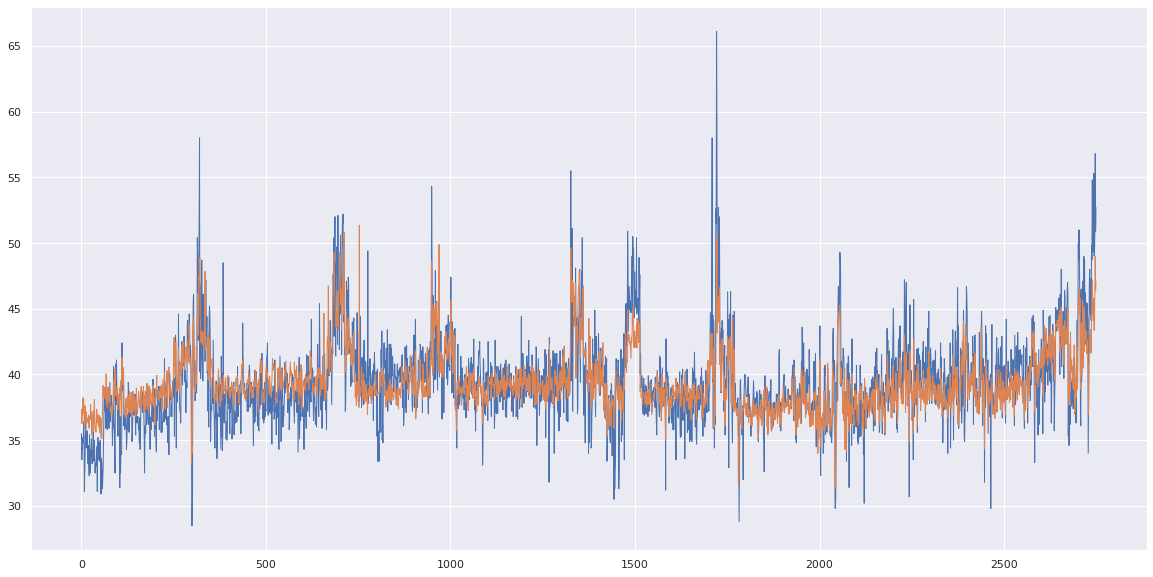

In [98]:
plt.figure(figsize = (20, 10))
plt.plot(np.arange(2750), target, lw = 1, label = 'target')
plt.plot(np.arange(2750), inferential, lw = 1, label = 'inf')

# XGBoost

In [99]:
xgb = XGBRegressor()
xgb.fit(train_input, train_target)
print(f'train_R2: {xgb.score(train_input, train_target)}')
print(f'test_R2: {xgb.score(test_input, test_target)}')
print(f'R2: {r2_score(target, xgb.predict(input_poly))}')
inferential = xgb.predict(input_poly)
print(f'MAE: {MAE(target, inferential)}')
print(f'MSE: {MSE(target, inferential)}')

[02:40:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train_R2: 0.6967568319231728
test_R2: 0.5866867066525663
R2: 0.6332513392371397
MAE: 1.486421334700151
MSE: 4.108124934105611


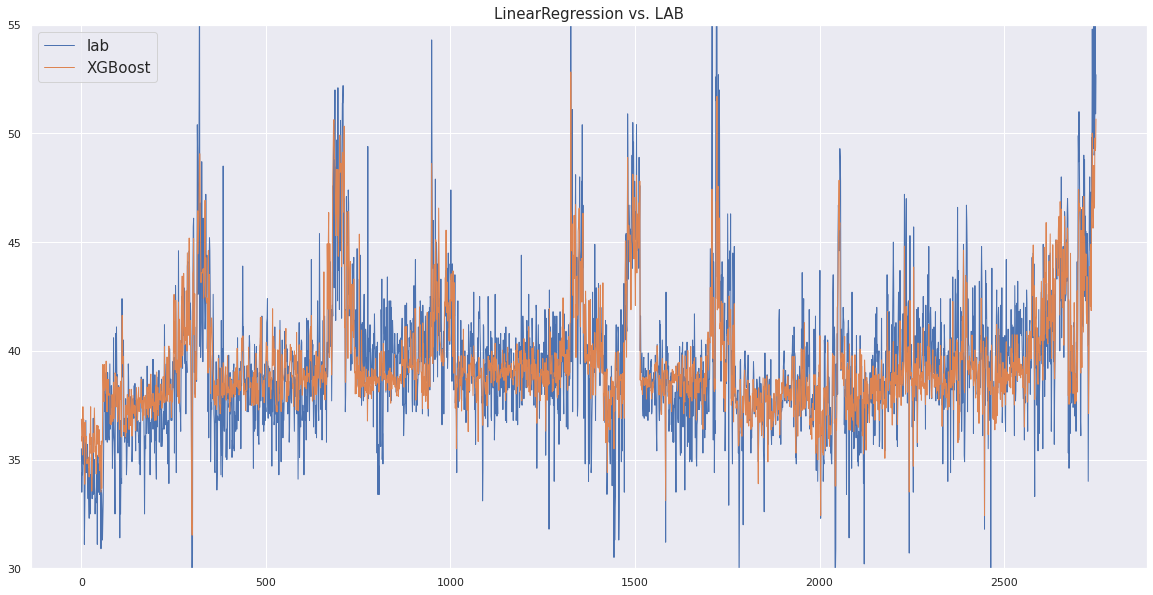

In [100]:
plt.figure(figsize = (20, 10))
plt.plot(np.arange(2750), target, label = 'lab', lw = 1)
plt.plot(np.arange(2750), inferential, label = 'XGBoost', lw = 1)
plt.ylim(30, 55)
plt.legend(fontsize = 15)
plt.title('LinearRegression vs. LAB', fontsize = 15)
plt.savefig('inf_.xgbregressor.png', dpi = 300, bbox_inches = 'tight')
plt.show()